# Vizgen Mouse Liver Squidpy Vignette
This vignette shows how to use Squidpy and Scanpy to analyze MERFISH data from the [Vizgen MERFISH Mouse Liver Map](https://info.vizgen.com/mouse-liver-access). This notebook analyzes the Liver1Slice1 MERFISH dataset that measures 347 genes across over >300,000 liver cells in a single mouse liver slice.

In [37]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy.cluster import hierarchy as sch

from matplotlib import pyplot as plt

import scanpy as sc
import squidpy as sq

%matplotlib inline

## Single-Cell Clustering of Vizgen MERFISH Mouse Liver Data
### Obtain Data from Vizgen 
We will use the Liver1Slice1 dataset from Vizgen's MERFISH Mouse Liver Map: https://info.vizgen.com/mouse-liver-access. In order to run this tutorial we will download the `cell_by_gene.csv` and `meta_cell.csv`. Please follow the instructions to obtain access to the showcase data and download the data - here we save the data to a directory called `tutorial_data/` in the same directory as this notebook.

### Load MERFISH Data into AnnData Object
First, we load the cell-by-gene and cell-metadata CSVs and construct an AnnData object `adata`.

In [2]:
adata = sc.read_h5ad("../data/vizgen/vizgen_data.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 75890 × 347
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'leiden', 'Endothelial cells', 'Stromal cells', 'Hepatocytes', 'Cholangiocytes', 'HsPCs', 'cDC2s', 'Mig. cDCs', 'Monocytes and Monocytes-derived cells', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kuppfer cells', 'Cleanliness', 'annotation', 'Hep', 'score_celltype_own_score_genes', 'second_score_celltype_own_score_genes', 'cleanliness_own_score_genes', 'annotation_own_score_genes_start_iterative', 'annotation_own_score_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'annotation_colors', 'annotation_own_score_genes_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'own_s

Make gene names unique and calculate QC metrics

In [4]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True
)

Filter cells with low expression and genes that are expressed in too few cells.

### UMAP with Leiden Clustering Labels
Here we visualize the distributions of the Leiden clusters in the UMAP plot. We see Leiden clusters tend to segregate into distinct regions within the UMAP plot.

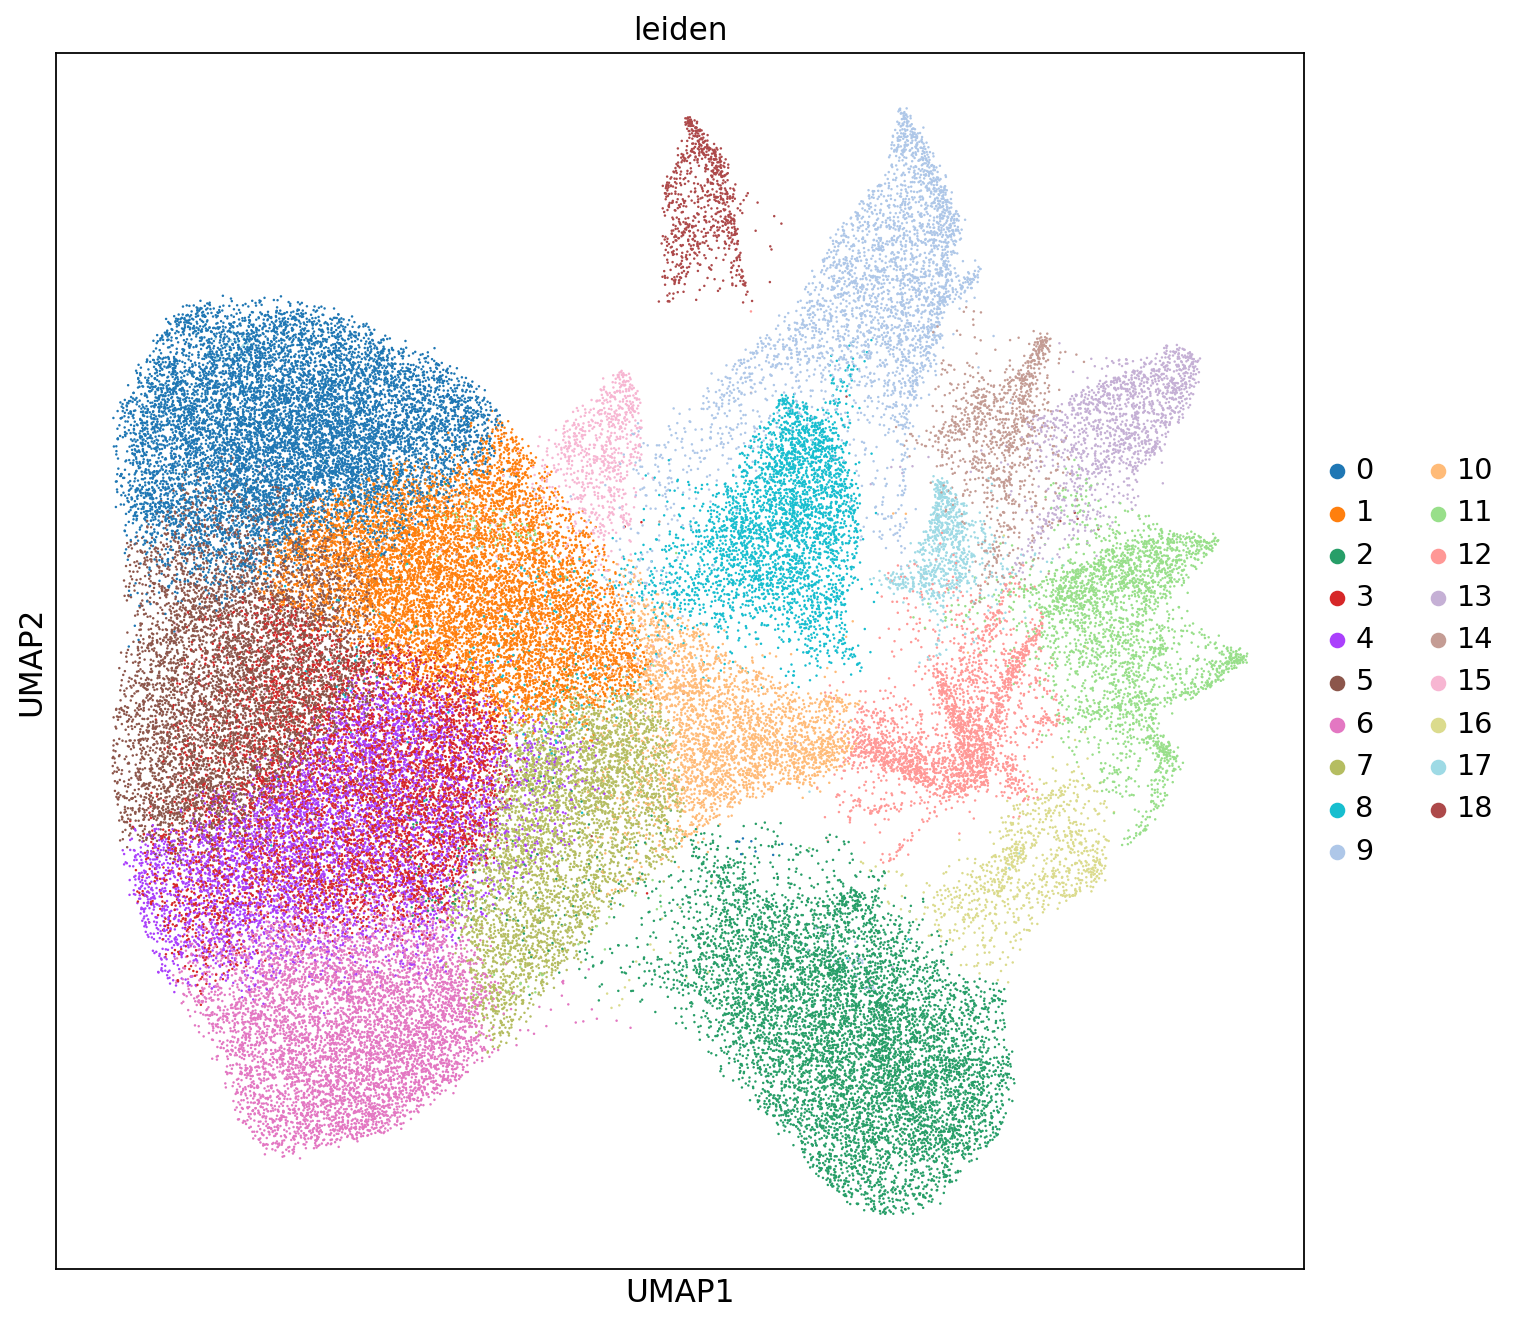

In [5]:
sc.set_figure_params(figsize=(10, 10))
sc.pl.umap(adata, color=["leiden"], size=5)

### Spatial Distributions of Cells
Here we visualize the spatial locations of cells in the mouse liver colored by Leiden cluster. We observe distinct spatial localizations of Leiden clusters throughout the tissue. We see some clusters line blood vessels and while others form concentric patterns reflecting hepatic zonation ([Cunningham et. al. 2021](https://www.frontiersin.org/articles/10.3389/fphys.2021.732929/full)). Our next step is to assign tentative cell type to our Leiden clusters and assess their spatial localizations in the liver.

/home/chananchidas/miniconda3/envs/nichecompass/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


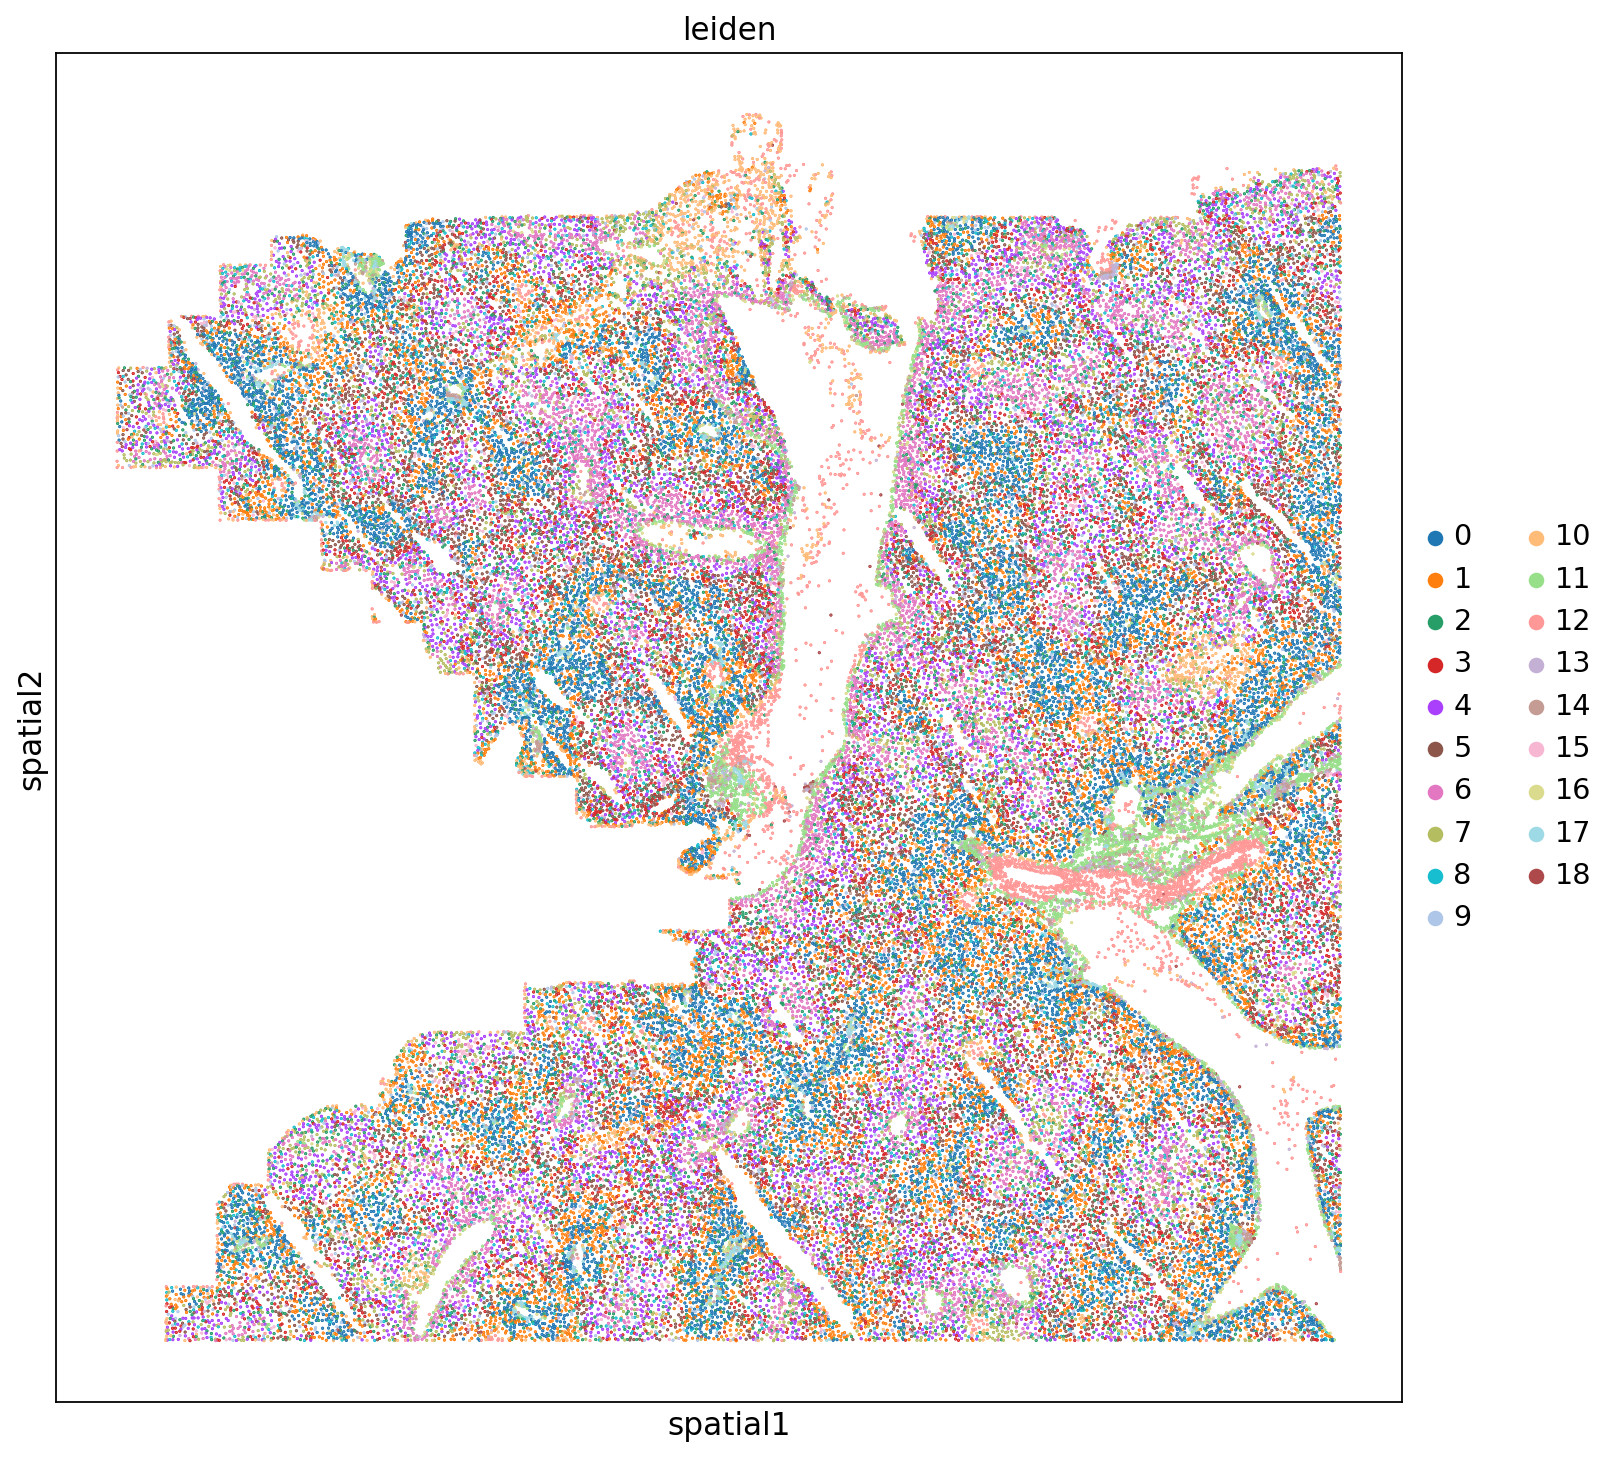

In [6]:
sq.pl.spatial_scatter(
    adata, shape=None, color="leiden", size=0.5, library_id="spatial", figsize=(10, 10)
)

## Neighborhood Enrichment
In this section we will use Squidpy to identify clusters that are spatially enriched for one another using a neighborhood enrichment test {func}`squidpy.gr.nhood_enrichment`. This test determines if cells belonging to two different clusters are close to each other more often than expected. 

In order to run this test we first have to calculate a connectivity graph using the {func}`squidpy.gr.spatial_neighbors` method. This graph consists of cells (nodes) and cell-cell interactions (edges). 

We also visualize the neighborhood enrichment using a hierarchically clustered heatmap which shows clusters of enriched neighborhoods in our tissue.

/home/chananchidas/miniconda3/envs/nichecompass/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


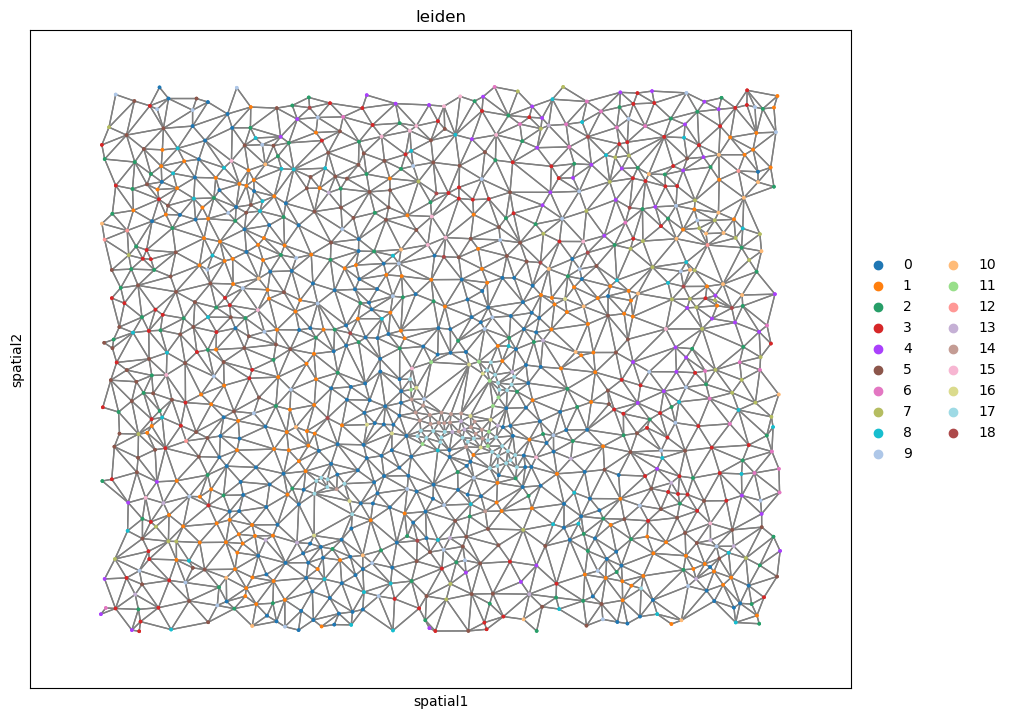

In [13]:
sq.pl.spatial_scatter( adata, shape=None, color="leiden", size=10, library_id="spatial", figsize=(10, 10),
                      crop_coord=(10000, 8000, 15000, 12000),
                      connectivity_key="spatial_connectivities"
                      )

100%|██████████| 1000/1000 [00:02<00:00, 428.26/s]


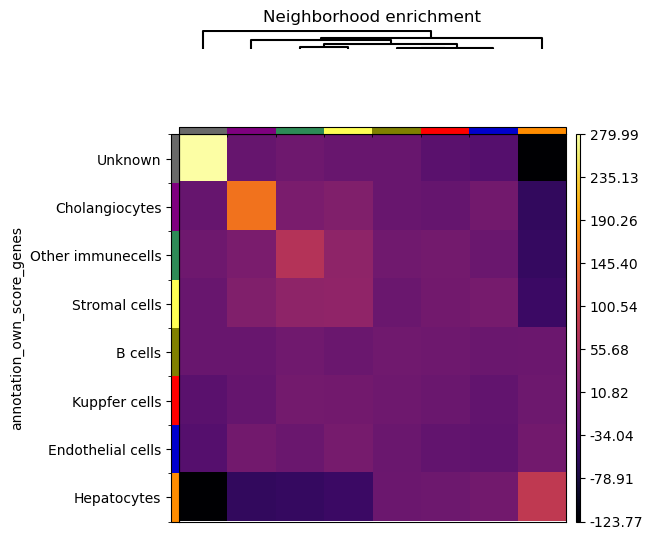

In [6]:
sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", delaunay=True)
sq.gr.nhood_enrichment(adata, cluster_key="annotation_own_score_genes")

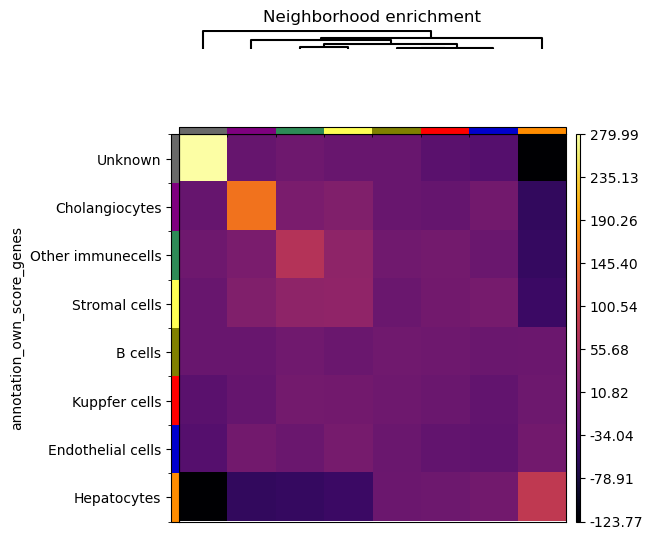

In [36]:
sq.pl.nhood_enrichment(
    adata,
    cluster_key="annotation_own_score_genes",
    method="average",
    cmap="inferno",
    figsize=(5, 5),
)

In [ ]:
# Check if this is the same as in Giotto if max_dist=NULL
adata.obsp["spatial_connectivities"].nnz // 2

In [ ]:
adata.uns["spatial_neighbors"]

{'connectivities_key': 'spatial_connectivities',
 'distances_key': 'spatial_distances',
 'params': {'n_neighbors': 6,
  'coord_type': 'generic',
  'radius': None,
  'transform': None}}

In [34]:
adata.obs["annotation_own_score_genes"].cat.categories

Index(['B cells', 'Cholangiocytes', 'Endothelial cells', 'Hepatocytes',
       'Kuppfer cells', 'Other immunecells', 'Stromal cells', 'Unknown'],
      dtype='object')

In [35]:
adata.uns['annotation_own_score_genes_nhood_enrichment']
np.savetxt("../rds/vizgen_squidpy_nhood_enrichment_zscore.txt", adata.uns['annotation_own_score_genes_nhood_enrichment']['zscore'], delimiter="\t")
np.savetxt("../rds/vizgen_squidpy_nhood_enrichment_count.txt", adata.uns['annotation_own_score_genes_nhood_enrichment']['count'], delimiter="\t")

## Network Centrality Scores
In addition to neighborhood enrichment we can also calculate network-based centrality scores for the Leiden clusters. These include 

* closeness centrality: how close a group is to other nodes
* degree centrality: fraction of connected non-group members
* clustering coeffeicient: measure of the degree to which nodes cluster

In [21]:
sq.gr.centrality_scores(adata, "leiden")
sc.set_figure_params(figsize=(20, 8))

# copy centrality data to new DataFrame
df_central = deepcopy(adata.uns["leiden_centrality_scores"])
df_central.index = meta_leiden.index.tolist()

# sort clusters based on centrality scores
################################################
# closeness centrality - measure of how close the group is to other nodes.
ser_closeness = df_central["closeness_centrality"].sort_values(ascending=False)

# degree centrality - fraction of non-group members connected to group members.
# [Networkx](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)
# The degree centrality for a node v is the fraction of nodes it is connected to.
ser_degree = df_central["degree_centrality"].sort_values(ascending=False)

# clustering coefficient - measure of the degree to which nodes cluster together.
ser_cluster = df_central["average_clustering"].sort_values(ascending=False)